# Import Library and data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from string import punctuation
from nltk.corpus import stopwords
stop_list = stopwords.words("english")
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.sparse import hstack, csr_matrix
import re

In [36]:
train_data = pd.read_csv("./train_data.csv", encoding="UTF-8")
test_data = pd.read_csv("./test_tweets_data.csv")

In [37]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [38]:
train_data.shape

(31962, 3)

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [40]:
train_data.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [41]:
train_data.label.value_counts()[1] / (train_data.label.value_counts()[0] + train_data.label.value_counts()[1])

0.07014579813528565

- Only __7 %__ data belongs to hate speech label __Imbalance Dataset problem__

In [42]:
train_data_op = train_data.copy()

# EDA

In [43]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

word_freq = gen_freq(train_data_op.tweet.str)

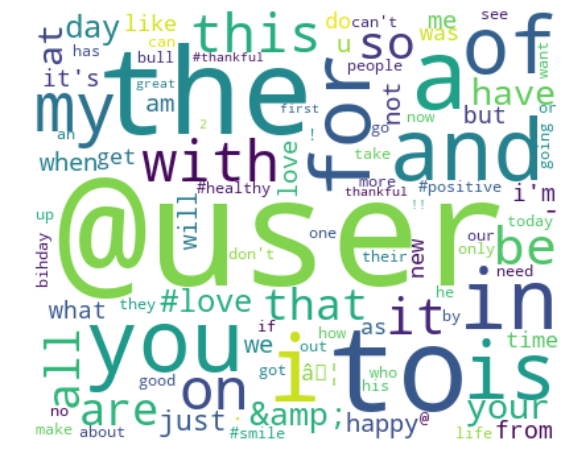

In [44]:
#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Most Common objects in tweets

In [45]:
## Mentioned User
users = re.findall(r"@[\w]+", ' '.join(train_data_op["tweet"]) )
Counter(users)

Counter({'@user': 17571})

In [46]:
## Most used hashtags
hashtags = re.findall(r"#[\w]+", ' '.join(train_data_op["tweet"]) )
Counter(hashtags).most_common(50)

[('#love', 1542),
 ('#positive', 874),
 ('#healthy', 571),
 ('#smile', 548),
 ('#thankful', 491),
 ('#fun', 434),
 ('#life', 406),
 ('#summer', 367),
 ('#model', 365),
 ('#affirmation', 363),
 ('#cute', 354),
 ('#i_am', 352),
 ('#blog', 346),
 ('#me', 336),
 ('#fathersday', 333),
 ('#silver', 299),
 ('#gold', 298),
 ('#altwaystoheal', 295),
 ('#beautiful', 283),
 ('#bihday', 278),
 ('#music', 274),
 ('#family', 272),
 ('#forex', 265),
 ('#weekend', 265),
 ('#selfie', 258),
 ('#friends', 256),
 ('#day', 254),
 ('#orlando', 236),
 ('#happiness', 235),
 ('#friday', 225),
 ('#instagood', 213),
 ('#blessed', 200),
 ('#healing', 184),
 ('#peace', 176),
 ('#trump', 176),
 ('#sun', 171),
 ('#motivation', 166),
 ('#girl', 166),
 ('#quote', 161),
 ('#grateful', 161),
 ('#photooftheday', 158),
 ('#sunday', 156),
 ('#work', 153),
 ('#followme', 153),
 ('#fashion', 144),
 ('#funny', 141),
 ('#a', 137),
 ('#dog', 136),
 ('#tbt', 130),
 ('#euro2016', 129)]

# Text Cleaning

In [47]:
def _cleanTweet(text):
    
    #lowercasing the text
    cleaned = text.lower()
    
    #removing @user as it is common for all
    cleaned = re.sub("@user","",cleaned)
    cleaned = re.sub("&amp","",cleaned)
    
    
    #Removing Punctuations
    cleaned = "".join(w for w in cleaned if w not in punctuation)
    
    #Removing stopwords
    cleaned = " ".join([w for w in cleaned.split() if w not in stop_list])
    
    #Apply Lemmatization
    lemmatizer = WordNetLemmatizer()
    cleaned = " ".join([lemmatizer.lemmatize(w, "v") for w in cleaned.split()])
    cleaned = " ".join([lemmatizer.lemmatize(w, "n") for w in cleaned.split()])
    
    
    return cleaned
    
_cleanTweet("I will be playing cricket tommorrow!! @user &amp;")

'play cricket tommorrow'

# Feature Engg

In [48]:
pos_dic = {"noun": ["NNP", "NN", "NNS", "NNPS"], "verb":["VBZ", "VB","VBD","VBN"]}
import nltk
def pos_check (txt, family):
    tags = nltk.pos_tag(nltk.word_tokenize(txt))
    count =0
    for tag in tags:
        tag = tag[1]
        if tag in pos_dic[family]:
            count += 1
    return count

pos_check("They are playing in the ground","noun")

1

In [49]:
def createMetaFeatures(dataset):
    
    dataset["word_count"] = dataset.tweet.apply(lambda x: len(x.split()))
    dataset["word_count_cleaned"] = dataset.cleaned_tweet.apply(lambda x: len(x.split()))

    dataset["char_count"] = dataset.tweet.apply(lambda x: len(x))
    dataset["char_count_without_space"] = dataset.tweet.apply(lambda x: len(x.replace(' ','')))

    dataset["number_of_digit"] = dataset.cleaned_tweet.apply(lambda x: sum([1 if  w.isdigit() else 0 for w in x.split()]))
    
    dataset["noun_count"] = dataset.tweet.apply(lambda x:pos_check(x, "noun"))
    dataset["verb_count"] = dataset.tweet.apply(lambda x:pos_check(x, "verb"))

    return dataset

In [50]:
import pickle

with open('../../Word_Embeddings_in_Action_-_GloVe/Word Embeddings in Action - GloVe/glove.6B.300d.pkl', 'rb') as fp:
    # load glove from disk 
    glove = pickle.load(fp)

In [51]:
# returns vector reperesentation of a given word if it is present in vocabulary
def get_embedding_glove(doc_tokens):
    embeddings = []
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if tok in glove:
            embeddings.append(glove[tok])
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

In [52]:
def applyingVectorizer(dataset):
    tf_idf_vec = TfidfVectorizer(max_features=3000)
    tf_idf_vec.fit(dataset.cleaned_tweet.values)
    tf_idf_matrix = tf_idf_vec.transform(dataset.cleaned_tweet.values)
    
    meta_features = ["word_count", "word_count_cleaned", "char_count","char_count_without_space","number_of_digit","noun_count","verb_count"]

    feature_set_1 = dataset[meta_features]

    train = hstack([tf_idf_matrix, csr_matrix(feature_set_1)], "csr")
    
    return train

In [53]:
def applyEmbeddingsGlove(dataset):
    X_embed = dataset["tweet"].apply(lambda x: get_embedding_glove(x))
    X_embed = pd.DataFrame(X_embed.tolist())
    meta_features = ["word_count", "word_count_cleaned", "char_count","char_count_without_space","number_of_digit","noun_count","verb_count"]

    feature_set_1 = dataset[meta_features]

    train = hstack([X_embed, csr_matrix(feature_set_1)], "csr")
    
    return train

In [69]:
def stackingAllSteps(dataset):
    
    dataset["cleaned_tweet"] = dataset["tweet"].apply(_cleanTweet)
    dataset = createMetaFeatures(dataset)
    X = applyEmbeddingsGlove(dataset)
    return X

In [61]:
train_X = stackingAllSteps(train_data_op)

In [62]:
train_X

<31962x307 sparse matrix of type '<class 'numpy.float64'>'
	with 9772555 stored elements in Compressed Sparse Row format>

In [63]:
Y = train_data_op["label"]

# Model Buiding

In [64]:
X_train, X_test, y_train, y_test = train_test_split(train_X, Y, random_state=12, test_size = 0.2)

In [66]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    classifier.fit(X_train, y_train)   
    print(classifier)
    y_pred = classifier.predict(X_test)
    print("model score: %.3f" % f1_score(y_test, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
model score: 0.235
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
model score: 0.304


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model score: 0.292
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
model score: 0.198
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='au

In [70]:
test_data_X = stackingAllSteps(test_data)

In [72]:
test_data_X

<17197x307 sparse matrix of type '<class 'numpy.float64'>'
	with 5258084 stored elements in Compressed Sparse Row format>

In [71]:
rf = RandomForestClassifier()
rf.fit(train_X, Y)
pred_test = rf.predict(test_data_X)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [73]:
test_data

,id,tweet,word_count,cleaned_tweet,word_count_cleaned,char_count,char_count_without_space,number_of_digit,noun_count,verb_count
0,31963,#studiolife #aislife #requires #passion #dedic...,9,studiolife aislife require passion dedication ...,8,90,79,0,3,2
1,31964,@user #white #supremacists want everyone to s...,16,white supremacist want everyone see new â bi...,11,101,82,0,7,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,9,safe way heal acne altwaystoheal healthy heal,7,71,57,0,2,1
3,31966,is the hp and the cursed child book up for res...,22,hp curse child book reservation already yes ð...,11,142,119,0,5,1
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",15,3rd bihday amaze hilarious nephew eli ahmir un...,11,93,76,0,5,1
...,...,...,...,...,...,...,...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,11,think factory leftright polarisation trump use...,11,108,96,0,7,0
17193,49156,feeling like a mermaid ð #hairflip #neverre...,13,feel like mermaid ð hairflip neverready for...,12,96,82,0,6,0
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,17,hillary campaign today ohioomg use word like a...,13,145,126,0,11,3
17195,49158,"happy, at work conference: right mindset leads...",12,happy work conference right mindset lead cultu...,10,104,90,0,6,1


In [74]:
test_data["label"] = pred_test
test_data.to_csv("submission.csv", columns=["id","label"], index=False )

# Using Deep Learning

In [8]:
from keras.callbacks import EarlyStopping
from sklearn.utils import resample

In [9]:
train_data_d = pd.read_csv("./train_data.csv", encoding="UTF-8")
test_data_d = pd.read_csv("./test_tweets_data.csv")

In [10]:
train_data_d.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [23]:

df_majority = train_data_d[train_data_d.label==0]
df_minority = train_data_d[train_data_d.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

0    29720
1     8000
Name: label, dtype: int64

In [24]:
train_data_d = df_upsampled.copy()

In [25]:
from keras.utils import to_categorical

# convert labels to categorical form
y = to_categorical(train_data_d.label)


In [26]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data_d['tweet'], y, test_size=0.1, random_state=42)
total_X = X_train.append(X_test)

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_X)

# convert text as sequence of tokens
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# calculate maximum length of sequence and vocab size
max_len = total_X.str.split().apply(lambda x: len(x)).max()
vocab_size = len(tokenizer.word_index)+1

In [27]:
from keras.preprocessing.sequence import pad_sequences

# pad train and test's text sequences to make them all of uniform length
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_len, padding='post')

print(X_train_pad.shape)

(33948, 34)


In [28]:
import keras.backend as K

In [29]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten

es = EarlyStopping(monitor='val_get_f1', mode='max', patience=2)
# embedding size
EMBEDDING_SIZE = 300
vocab_100 = int(vocab_size/50)

# initialize a sequential model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_len))
model.add(Dense(500, activation='relu'))
model.add(Dense(vocab_100, activation='relu'))
model.add(Flatten())
# add the final layer that will classify into 5 classes
model.add(Dense(2, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])

In [40]:
# check model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 34, 300)           13745100  
_________________________________________________________________
dense_7 (Dense)              (None, 34, 500)           150500    
_________________________________________________________________
dense_8 (Dense)              (None, 34, 916)           458916    
_________________________________________________________________
flatten_3 (Flatten)          (None, 31144)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 62290     
Total params: 14,416,806
Trainable params: 14,416,806
Non-trainable params: 0
_________________________________________________________________


In [41]:
# train and evaluate the model
model.fit(X_train_pad, y_train, epochs=11, validation_data=(X_test_pad, y_test), callbacks=[es])

Train on 33948 samples, validate on 3772 samples
Epoch 1/11
33948/33948 [==============================] - 186s 5ms/step - loss: 0.1557 - get_f1: 0.9415 - val_loss: 0.0666 - val_get_f1: 0.9821
Epoch 2/11
33948/33948 [==============================] - 185s 5ms/step - loss: 0.0233 - get_f1: 0.9923 - val_loss: 0.0932 - val_get_f1: 0.9723
Epoch 3/11
33948/33948 [==============================] - 182s 5ms/step - loss: 0.0081 - get_f1: 0.9975 - val_loss: 0.1221 - val_get_f1: 0.9751


In [92]:
model.save('Twitter_Hate_Speech.h5')

In [94]:
import pickle
 
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
import tensorflow as tf

In [98]:
test_data_d.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [42]:
test_data_seq = tokenizer.texts_to_sequences(test_data_d["tweet"])
test_pad = pad_sequences(test_data_seq, maxlen=max_len, padding='post')
pred = model.predict_classes(test_pad)
print(pred)

[0 1 0 ... 0 0 0]


In [43]:
test_data_d["label"] = pred
test_data_d.to_csv("submission.csv", columns=["id","label"], index=False )